In [ ]:
!pip install torchvision
!pip install wandb
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
from tqdm import tqdm
import wandb

# Requiremments and imports
I

In [ ]:
# force pytorch to use GPU if available
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NUM_SAMPLES = 12
RUN_NAME = 'baseline'
SEED = 0

# values for model dimensions
LATENT_DIMS = 100
NUM_GEN_KERN = 128
NUM_DISC_KERN = 128
NUM_CHANNELS = 1
BATCH_SIZE = 128

# parameters for training
LEARNING_RATE = 0.0001
BETA1 = 0.5
BETA2 = 0.999
EPOCHS = 20

In [ ]:
def prepare_data(BATCH_SIZE):

    num_cores = os.cpu_count()

    # transformations to apply to the images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])

    # download data
    train_set = torchvision.datasets.MNIST(
        'content/train',
        train=True,
        download = True,
        transform=transformation
    )

    # crop dataset so batch size divides evenly
    dataset_size = len(train_set)
    trimmed_dataset_size = dataset_size - (dataset_size % BATCH_SIZE)
    train_set.data = train_set.data[:trimmed_dataset_size]
    train_set.targets = train_set.targets[:trimmed_dataset_size]


    # create data loader
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_cores
        )

    return train_loader


def initialize_weights(mod):
    # initialize weights to normal distribution
    if isinstance(mod, nn.Conv2d) or isinstance(mod, nn.ConvTranspose2d):
        nn.init.normal_(mod.weight, 0.0, 0.02)
    elif isinstance(mod, nn.BatchNorm2d):
        nn.init.normal_(mod.weight, 1.0, 0.02)
        nn.init.constant_(mod.bias, 0)


def reset_gradients(network):
    # reset gradients
    for param in network.parameters():
        param.grad = None


def model_setup(device=DEVICE):
    # initialize models
    generator = Generator()
    generator.apply(initialize_weights)
    generator.to(device)

    discriminator = Discriminator()
    discriminator.apply(initialize_weights)
    discriminator.to(device)

    # initialize optimizers
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

    # initialize loss function
    calc_loss = nn.BCELoss()

    return generator, discriminator, gen_optimizer, disc_optimizer, calc_loss

def train_setup(images, discriminator):
    # train setup

    actual_images = images.to(DEVICE)
    real_batch_size = discriminator(actual_images).view(-1).size(0)
    real_label = torch.ones((real_batch_size, ), dtype=torch.float32, device=DEVICE)
    fake_label = torch.zeros((real_batch_size, ), dtype=torch.float32, device=DEVICE)

    return actual_images, real_batch_size, real_label, fake_label

In [ ]:
class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()

    # set up model architecture
    # 4 convoloutions total
    # input batch_size1x1x1 vector
    # output batch_size1x28x28
    self.network = nn.Sequential(
        nn.ConvTranspose2d(
            in_channels=LATENT_DIMS,
            out_channels=NUM_GEN_KERN * 4  ,
            kernel_size=4,
            stride=2,
            padding=0,
            bias=False
            ),
        nn.BatchNorm2d(NUM_GEN_KERN * 4),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=NUM_GEN_KERN * 4,
            out_channels=NUM_GEN_KERN * 2,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.BatchNorm2d(NUM_GEN_KERN * 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=NUM_GEN_KERN * 2,
            out_channels=NUM_GEN_KERN,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.BatchNorm2d(NUM_GEN_KERN),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=NUM_GEN_KERN,
            out_channels=NUM_CHANNELS,
            kernel_size=4,
            stride=2,
            padding=3,
            bias=False
            ),
        nn.Tanh(),
    )

  def forward(self, input):
    return self.network(input)



class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    # set up model architecture
    # 4 convoloutions total
    # input batch_size1x28x28
    # output batch_sizex1x1x1
    self.network = nn.Sequential(
        nn.Conv2d(
            in_channels=NUM_CHANNELS,
            out_channels=NUM_DISC_KERN,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(
            in_channels=NUM_DISC_KERN,
            out_channels=NUM_DISC_KERN * 2,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.BatchNorm2d(NUM_DISC_KERN * 2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(
            in_channels=NUM_DISC_KERN * 2,
            out_channels=NUM_DISC_KERN * 4,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.BatchNorm2d(NUM_DISC_KERN * 4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(
            in_channels=NUM_DISC_KERN * 4,
            out_channels=NUM_CHANNELS,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.Sigmoid()
        )

  def forward(self, input):
    return self.network(input)

In [ ]:
def run():

    # initialize projectname and config in wandb
    wandb.init(
        project='BASELINE-DCGAN',
        config={
        'num_samples': NUM_SAMPLES,
        'run_name': RUN_NAME,
        'seed': SEED,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'beta1': BETA1,
        'beta2': BETA2,
        'latent_dims': LATENT_DIMS,
        'num_gen_kern': NUM_GEN_KERN,
        'num_disc_kern': NUM_DISC_KERN,
        'num_channels': NUM_CHANNELS,
        'epochs': EPOCHS
    })

    config = wandb.config

    # create logs folder
    if not os.path.exists('/content/logs'):
      os.mkdir('/content/logs')
    if not os.path.exists(f'/content/logs/{config.run_name}'):
      os.mkdir(f'/content/logs/{config.run_name}')

    # set random seed
    manual_seed = config.seed
    random.seed(manual_seed)
    torch.manual_seed(manual_seed)


    # set cuda
    if torch.cuda.is_available():
      torch.cuda.manual_seed(manual_seed)
      torch.cuda.manual_seed_all(manual_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # create data loader
    train_loader = prepare_data(config.batch_size)

    # initialize models
    generator, discriminator, gen_optimizer, disc_optimizer, calc_loss = model_setup()

    # store losses
    gen_losses = []
    disc_losses = []
    real_confs = []
    fake_confs = []
    generated_confs = []

    # enable training
    discriminator.train()
    generator.train()

    for epoch in range(1, config.epochs + 1):

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):


            # train setup
            # grab a batch of images
            actual_images, real_batch_size, real_label, fake_label = train_setup(images, discriminator)

            # train discrim on real images
            reset_gradients(discriminator)

            out = discriminator(actual_images).view(-1)
            real_loss = calc_loss(out, real_label)
            real_loss.backward()
            real_conf = real_loss.mean().item()


            # 2: generate noise vector to generate image from
            noise = torch.randn(config.batch_size, config.latent_dims, 1, 1, device=DEVICE)

            # train discriminator on fake images
            fake_images = generator(noise)
            out = discriminator(fake_images.detach()).view(-1)
            fake_loss = calc_loss(out, fake_label)
            fake_loss.backward()
            fake_conf = fake_loss.mean().item()

            # find discriminator loss and perform step
            discriminator_loss = real_loss + fake_loss
            disc_optimizer.step()

            # 3: train generator
            reset_gradients(generator)

            out = discriminator(fake_images).view(-1)
            generator_loss = calc_loss(out, real_label)
            generator_loss.backward()
            generated_conf = generator_loss.mean().item()

            gen_optimizer.step()

            # track step metrics with wandb
            s_metrics = {
                'discriminator_loss': discriminator_loss.item(),
                'generator_loss': generator_loss.item(),
                'real_conf': real_conf,
                'fake_conf': fake_conf,
                'generated_conf': generated_conf
            }

            # collect losses and confidences
            gen_losses.append(generator_loss.item())
            disc_losses.append(discriminator_loss.item())
            real_confs.append(real_conf)
            fake_confs.append(fake_conf)
            generated_confs.append(generated_conf)

        discriminator_loss = sum(disc_losses) / len(disc_losses)
        generator_loss = sum(gen_losses) / len(gen_losses)
        real_conf = sum(real_confs) / len(real_confs)
        fake_conf = sum(fake_confs) / len(fake_confs)
        generated_conf = sum(generated_confs) / len(generated_confs)

        # track epoch metrics with wandb
        e_metrics = {
            'discriminator_loss': discriminator_loss,
            'generator_loss': generator_loss,
            'real_conf': real_conf,
            'fake_conf': fake_conf,
            'generated_conf': generated_conf,
        }

        wandb.log({**s_metrics, **e_metrics})

        print(f'Epoch ', epoch, '/', config.epochs, ': Discriminator Loss: ', sum(disc_losses) / len(disc_losses), 'Generator: ', sum(gen_losses) / len(gen_losses))

        # display and save generated images after training
        samples = []
        static_noise = torch.randn(real_batch_size, config.latent_dims, 1, 1, device=DEVICE)
        generator.eval()
        samples = generator(static_noise)

        grid = vutils.make_grid(samples[:24], normalize=True, scale_each=True)
        grid = grid.permute(1, 2, 0).cpu().numpy()
        grid = (grid * 255).astype(np.uint8)
        wandb.log({'samples': wandb.Image(grid)})

        if epoch % 5 == 0 or epoch == 1:
            plt.figure(figsize=(10, 10))
            for x in range(25):
                sample = samples[x]
                sample = np.reshape(sample.cpu().detach().numpy(), (28, 28))
                plt.subplot(5, 5, x + 1)
                plt.imshow(sample, cmap='gray')
                plt.axis('off')
            plt.show()
        generator.train()

        torch.save(generator.state_dict(), f'/content/logs/{config.run_name}/generator_{epoch}.pth')
        torch.save(discriminator.state_dict(), f'/content/logs/{config.run_name}/discriminator_{epoch}.pth')

        torch.cuda.empty_cache()
    wandb.finish()
    return generator, discriminator

wandb: Currently logged in as: mokasp (mokaspo). Use `wandb login --relogin` to force relogin


100%|██████████| 468/468 [00:56<00:00,  8.22it/s]


Epoch  1 / 20 : Discriminator Loss:  0.15800414262259874 Generator:  4.249586920972324


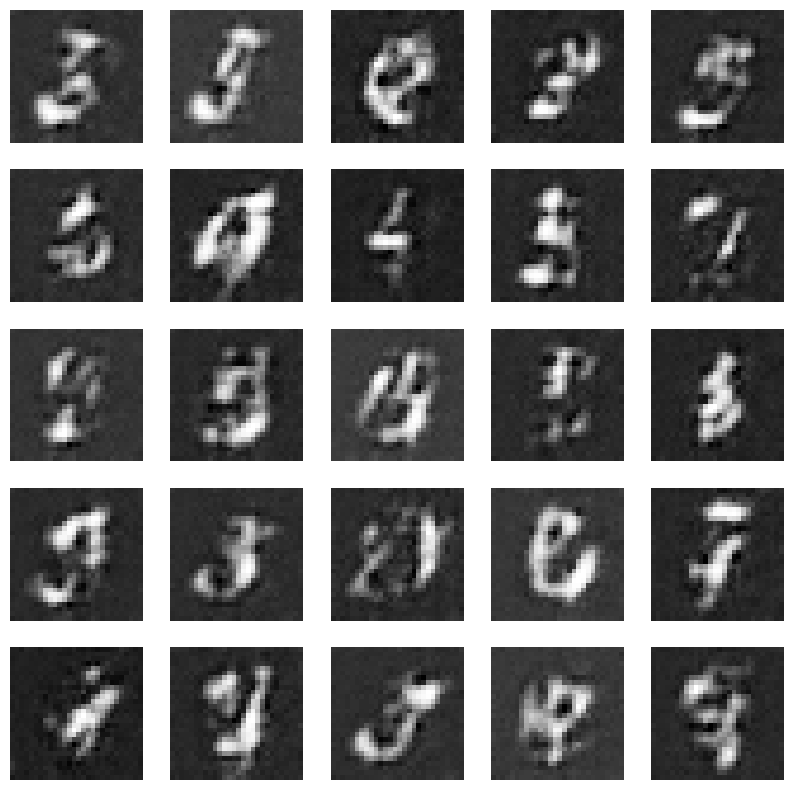

100%|██████████| 468/468 [00:57<00:00,  8.09it/s]


Epoch  2 / 20 : Discriminator Loss:  0.18611761135880986 Generator:  4.380765943282468


100%|██████████| 468/468 [00:58<00:00,  8.06it/s]


Epoch  3 / 20 : Discriminator Loss:  0.1270230226016383 Generator:  4.923432304539764


100%|██████████| 468/468 [00:58<00:00,  8.04it/s]


Epoch  4 / 20 : Discriminator Loss:  0.20374848944685744 Generator:  5.246292699728849


100%|██████████| 468/468 [00:58<00:00,  8.04it/s]


Epoch  5 / 20 : Discriminator Loss:  0.16925360810371817 Generator:  5.322055676448513


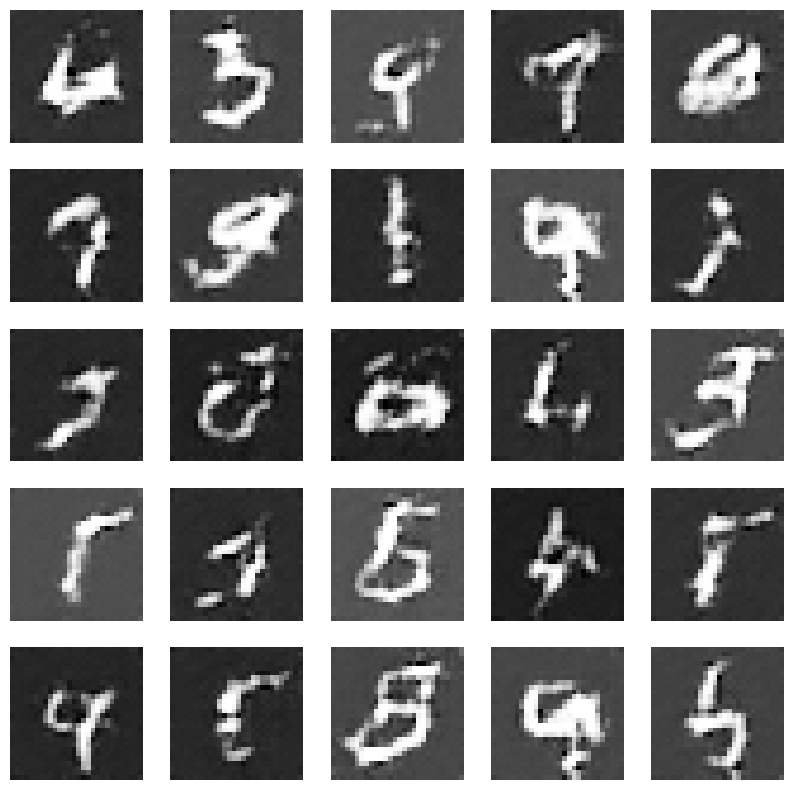

100%|██████████| 468/468 [00:58<00:00,  8.03it/s]


Epoch  6 / 20 : Discriminator Loss:  0.14142613880612565 Generator:  5.678205177651906


100%|██████████| 468/468 [00:58<00:00,  8.04it/s]


Epoch  7 / 20 : Discriminator Loss:  0.1213739409472715 Generator:  6.035366420632655


100%|██████████| 468/468 [00:58<00:00,  8.01it/s]


Epoch  8 / 20 : Discriminator Loss:  0.10628542274394139 Generator:  6.362701510769476


100%|██████████| 468/468 [00:58<00:00,  8.02it/s]


Epoch  9 / 20 : Discriminator Loss:  0.09452602998171539 Generator:  6.661515435147073


100%|██████████| 468/468 [00:58<00:00,  8.02it/s]


Epoch  10 / 20 : Discriminator Loss:  0.08510070546841995 Generator:  6.951339165775422


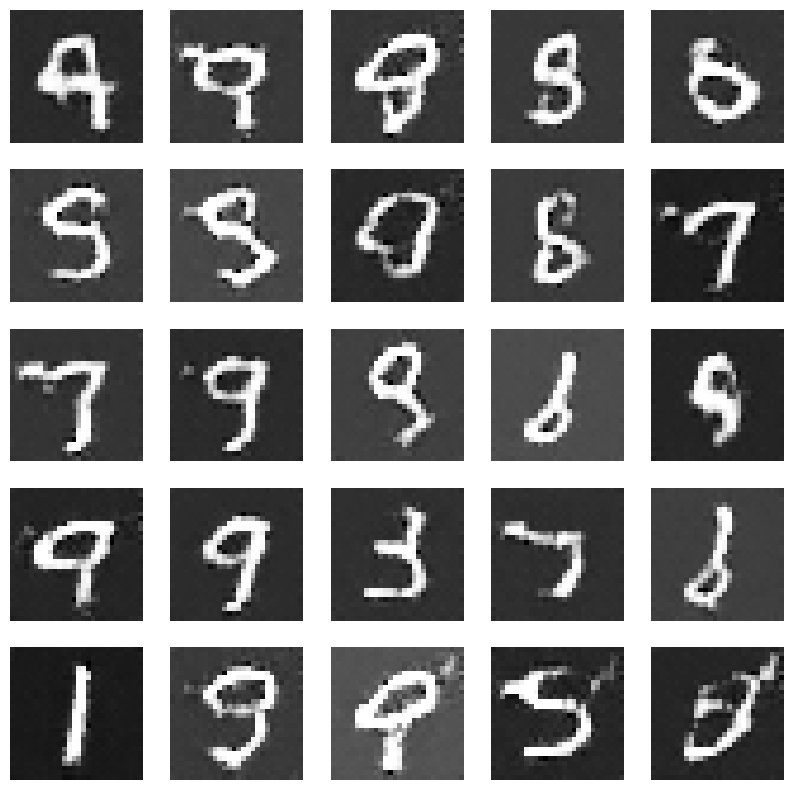

100%|██████████| 468/468 [00:58<00:00,  8.02it/s]


Epoch  11 / 20 : Discriminator Loss:  0.07738290824136447 Generator:  7.219749884170283


100%|██████████| 468/468 [00:58<00:00,  8.02it/s]


Epoch  12 / 20 : Discriminator Loss:  0.0709461874950876 Generator:  7.475578653505243


100%|██████████| 468/468 [00:58<00:00,  8.01it/s]


Epoch  13 / 20 : Discriminator Loss:  0.06549685940122162 Generator:  7.720248294768745


100%|██████████| 468/468 [00:58<00:00,  8.02it/s]


Epoch  14 / 20 : Discriminator Loss:  0.06082432331814822 Generator:  7.949916663331596


100%|██████████| 468/468 [00:58<00:00,  8.03it/s]


Epoch  15 / 20 : Discriminator Loss:  0.05677331645697955 Generator:  8.167438118001494


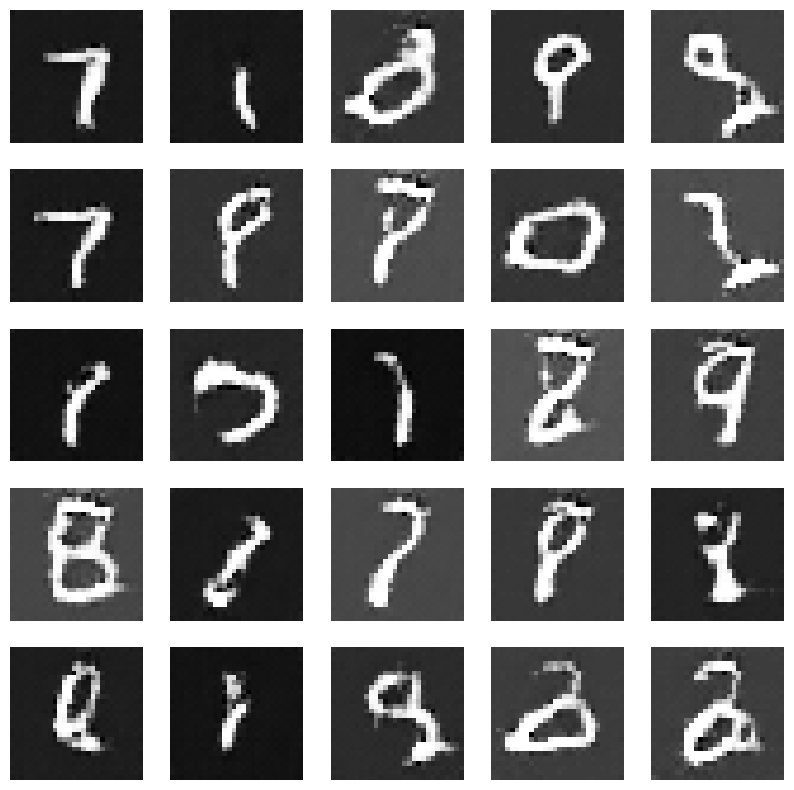

100%|██████████| 468/468 [00:58<00:00,  8.01it/s]


Epoch  16 / 20 : Discriminator Loss:  0.053227555869972465 Generator:  8.381207318386355


100%|██████████| 468/468 [00:58<00:00,  8.01it/s]


Epoch  17 / 20 : Discriminator Loss:  0.05009819845328808 Generator:  8.591889561570088


100%|██████████| 468/468 [00:58<00:00,  8.02it/s]


Epoch  18 / 20 : Discriminator Loss:  0.04731599775740828 Generator:  8.801253227652213


100%|██████████| 468/468 [00:58<00:00,  8.04it/s]


Epoch  19 / 20 : Discriminator Loss:  0.04482649961633999 Generator:  9.00125978350062


100%|██████████| 468/468 [00:58<00:00,  8.04it/s]


Epoch  20 / 20 : Discriminator Loss:  0.04258567676981356 Generator:  9.200439754102083


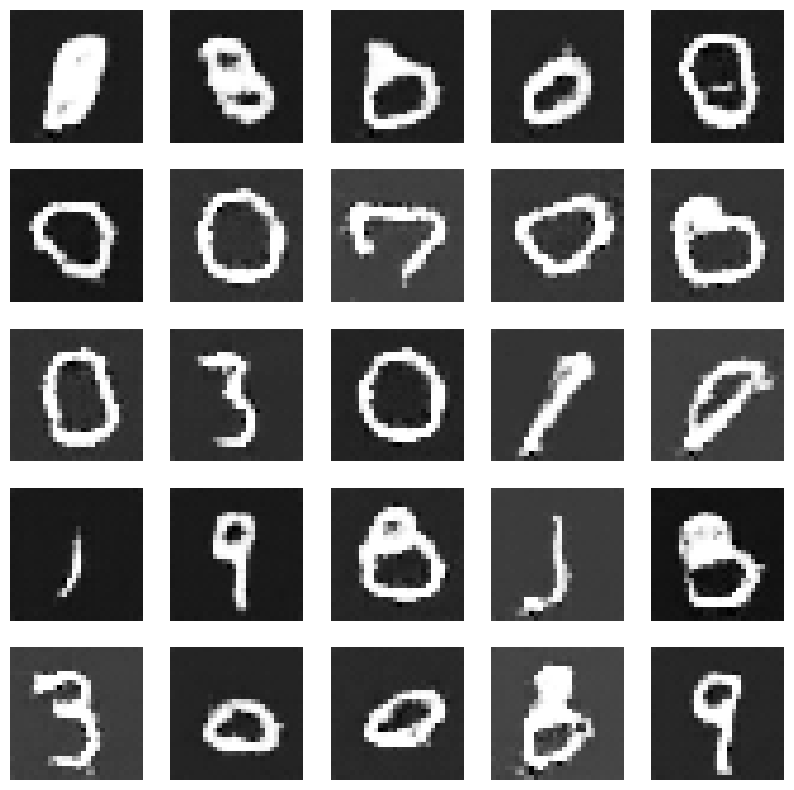

discriminator_loss,▆▇▅█▇▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
fake_conf,▄▆▄█▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁
generated_conf,▁▁▂▂▃▃▄▄▄▅▅▆▆▆▇▇▇▇██
generator_loss,▁▁▂▂▃▃▄▄▄▅▅▆▆▆▇▇▇▇██
real_conf,█▇▄▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
discriminator_loss,0.04259
fake_conf,0.03007
generated_conf,9.20044
generator_loss,9.20044
real_conf,0.01251


In [ ]:
gen, disc = run()